In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve

import xgboost as xgb
from sklearn.metrics import auc, roc_auc_score

sns.set(font_scale=1.4, style='white')

In [2]:
plt.style.use('seaborn-colorblind')

In [3]:
with open('../result/xgb_model.pkl', 'rb') as f:
    gbm = pickle.load(f)

In [4]:
with open('../result/feature_names.pkl', 'rb') as f:
    feature_name = pickle.load(f)

In [5]:
gain = gbm.get_booster().get_score(importance_type='gain')

In [6]:
f_gain, gscore = zip(*sorted(gain.items(), key=lambda x:x[1], reverse=True))
x = range(len(gain))

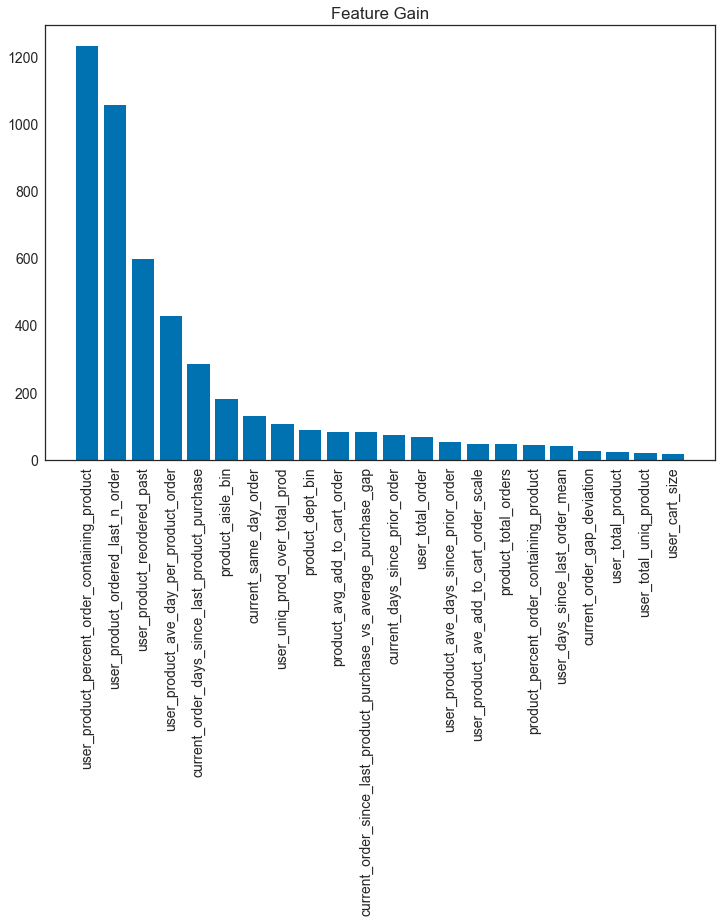

In [7]:
plt.figure(figsize=(12,8))
plt.bar(x, gscore)
plt.xticks(x,f_gain, rotation=90)
plt.title('Feature Gain');

In [8]:
gain_df = pd.DataFrame({'feature_names': list(gain.keys()), 'gain':list(gain.values())})

In [9]:
#get feature type
def feature_type(x):
    if x.startswith('user_product'):
        return'User-Product'
    if x.startswith('user_'):
        return 'User'
    if x.startswith('product'):
        return 'Product'
    else:
        return 'Order'
    

In [10]:
gain_df['feature_type'] = gain_df['feature_names'].transform(feature_type)

In [11]:
gain_df

,feature_names,gain,feature_type
0,user_product_ordered_last_n_order,1058.436854,User-Product
1,user_product_ave_day_per_product_order,427.939265,User-Product
2,user_product_ave_add_to_cart_order_scale,46.773854,User-Product
3,user_total_order,68.549966,User
4,user_days_since_last_order_mean,40.528398,User
5,current_order_since_last_product_purchase_vs_a...,81.623950,Order
6,product_dept_bin,89.406413,Product
7,product_aisle_bin,181.000913,Product
8,product_total_orders,45.605930,Product
9,user_product_percent_order_containing_product,1235.012513,User-Product


In [12]:
gain_df.to_csv('../result/feature_importance_gain.csv')

** Use Tableau to generate bar plot for feature importance.**  

** EDA on sample of the traing set data**

In [13]:
order_product = pd.read_csv('../raw_data/order_products__train.csv')
sample_df = order_product.sample(30000)
sample_df.shape

(30000, 4)

In [14]:
product_info=pd.read_csv('../raw_data/products.csv')

In [15]:
sample_df = pd.merge(sample_df, product_info, on='product_id')

In [16]:
dept = pd.read_csv('../raw_data/departments.csv')
sample_df=pd.merge(sample_df, dept, on='department_id', how='left')

In [17]:
no_reorder = sample_df.loc[sample_df['reordered']==0,'department_id'].value_counts().sort_index()/\
sample_df.loc[sample_df['reordered']==0,'department_id'].count()
reorder = sample_df.loc[sample_df['reordered']==1,'department_id'].value_counts().sort_index()/\
sample_df.loc[sample_df['reordered']==1,'department_id'].count()


In [18]:
dept_freq  = pd.DataFrame(no_reorder)
dept_freq.columns=['no_reorder']

In [19]:
dept_freq = pd.merge(dept_freq, reorder.to_frame(), left_index=True, right_index=True, how='outer')
dept_freq.fillna(0, inplace=True)

In [20]:
dept_freq.rename(columns={'department_id':'reordered'}, inplace =True)
dept_freq['diff'] = dept_freq['reordered'] - dept_freq['no_reorder']
dept_freq.sort_values('diff', ascending=False, inplace=True)

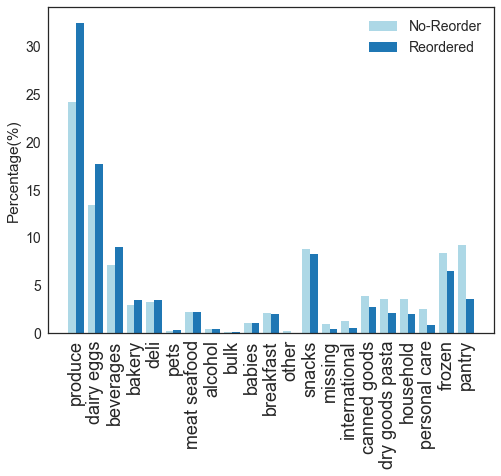

In [21]:
x=np.arange(len(dept_freq))
plt.figure(figsize=(8,6))
plt.bar(x, dept_freq['no_reorder']*100, width=0.4, label='No-Reorder', color='lightblue')
plt.bar(x+0.4, dept_freq['reordered']*100, width=0.4, label = 'Reordered', color='tab:blue')
plt.legend();
plt.ylabel('Percentage(%)')
plt.xticks(fontsize=18)
plt.xticks(x+0.2,dept.loc[dept_freq.index-1, 'department'], rotation=90);

In [22]:
aisle=pd.read_csv('../raw_data/aisles.csv')
sample_df=pd.merge(sample_df, aisle, on='aisle_id', how='left')


In [23]:
no_reorder = sample_df.loc[sample_df['reordered']==0,'aisle_id'].value_counts().sort_index()/\
sample_df.loc[sample_df['reordered']==0,'aisle_id'].count()
reorder = sample_df.loc[sample_df['reordered']==1,'aisle_id'].value_counts().sort_index()/\
sample_df.loc[sample_df['reordered']==1,'aisle_id'].count()


In [24]:
aisle_freq  = pd.DataFrame(no_reorder)
aisle_freq.columns=['no_reorder']
aisle_freq = pd.merge(aisle_freq, reorder.to_frame(), left_index=True, right_index=True, how='outer')

In [25]:
aisle_freq.fillna(0, inplace=True)

In [26]:
aisle_freq.rename(columns={'aisle_id':'reordered'}, inplace =True)
aisle_freq['diff'] = aisle_freq['reordered'] - aisle_freq['no_reorder']

In [27]:
aisle_freq.sort_values('diff', ascending=False, inplace=True)

As there are too many aisles, only top and bottom 10 aisles that show largest difference in the reorder frequecy are shown.

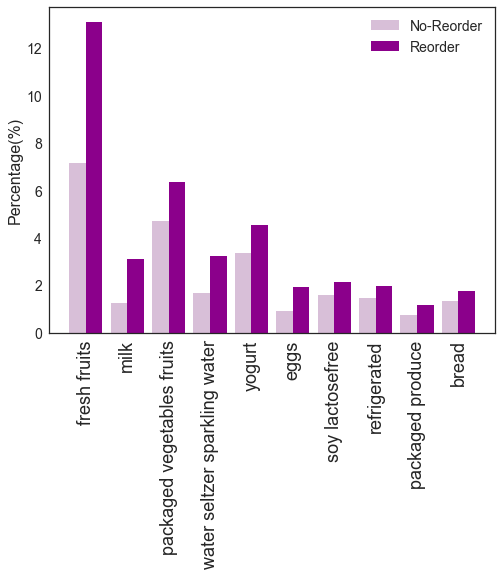

In [28]:
x=np.arange(10)
plt.figure(figsize=(8,6))
plt.bar(x, aisle_freq.iloc[0:10]['no_reorder']*100, width=0.4, label='No-Reorder', color='thistle')
plt.bar(x+0.4, aisle_freq.iloc[0:10]['reordered']*100, width=0.4, label = 'Reorder', color='darkmagenta')
plt.legend();
plt.xticks(fontsize=18)
plt.ylabel('Percentage(%)', fontsize=16)
plt.xticks(x+0.2,aisle.loc[aisle_freq.index[0:10]-1, 'aisle'], rotation=90, fontsize=18);

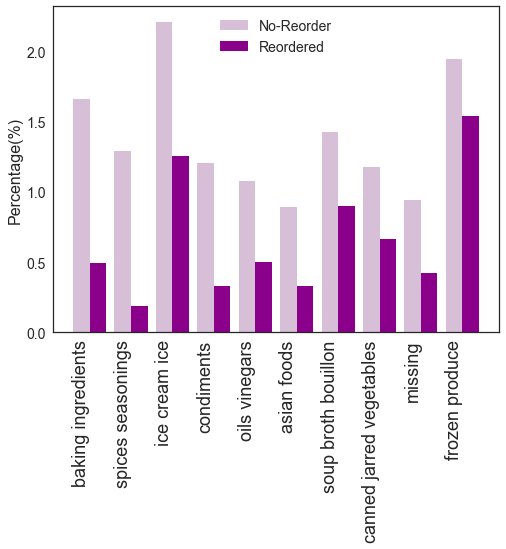

In [29]:
x=np.arange(10)
plt.figure(figsize=(8,6))
plt.bar(x, aisle_freq.iloc[-1:-11:-1]['no_reorder']*100, width=0.4, label='No-Reorder', color='thistle')
plt.bar(x+0.4, aisle_freq.iloc[-1:-11:-1]['reordered']*100, width=0.4, label = 'Reordered', color='darkmagenta')
plt.legend()
plt.ylabel('Percentage(%)', fontsize=16)
plt.xticks(x,aisle.loc[aisle_freq.index[-1:-11:-1]-1, 'aisle'], rotation=90,fontsize=18);